Imports

In [ ]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from google.colab import drive

In [ ]:
#drive access
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
#constants
IMAGE_WIDTH = 192
IMAGE_HEIGHT = 256
DATASET_PATH = '/content/drive/My Drive/Pest_Disease'
BATCH_SIZE = 32
EPOCHS = 25


Loading Dataset from directory

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 445 files belonging to 3 classes.


In [ ]:
classesList = dataset.class_names
print(classesList)

['Dots', 'good', 'pest']


Dataset head visualization

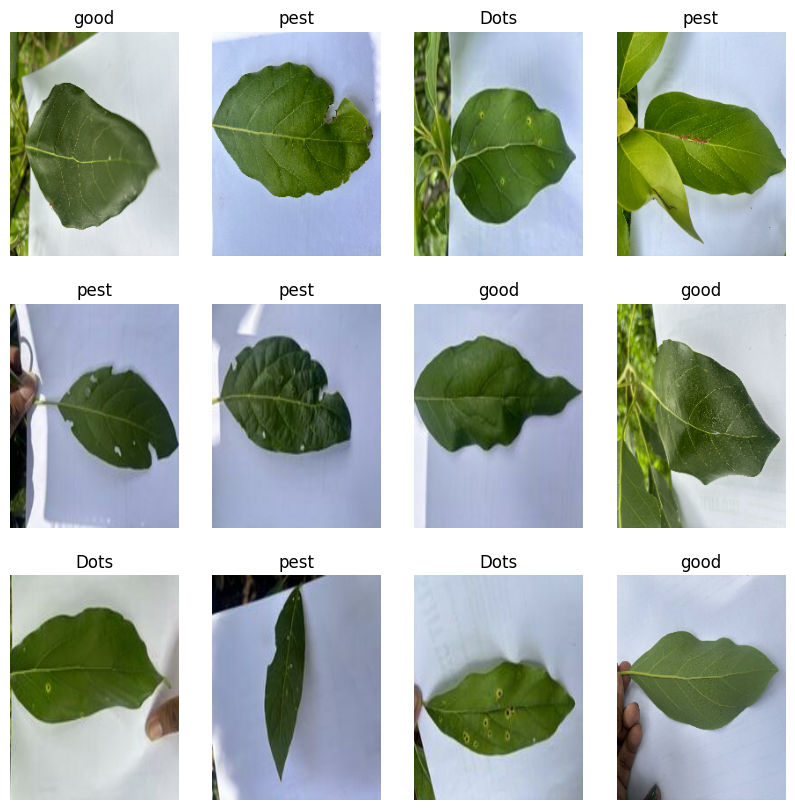

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for x in range (12):
        ax = plt.subplot(3,4, x+1)
        plt.axis("off")
        plt.title(classesList[label_batch[x]])
        img = image_batch[x].numpy().astype("uint8")
        plt.imshow(img)


Dataset partition to training, testing and validation set

In [ ]:
def trainTestSplit(dataset, trainRatio=0.8, testRatio=0.1, shuffle=True):
  if shuffle:
    np.random.shuffle(dataset)

  totalSize = len(dataset)
  trainSize = int(totalSize * trainRatio)
  testSize = int(totalSize * testRatio)

  trainingSet = dataset[:trainSize]
  validationSet = dataset[trainSize:trainSize + testSize]
  testingSet = dataset[trainSize + testSize:]

  return trainingSet, validationSet, testingSet

In [ ]:
trainingSet ,testingSet, validationSet= trainTestSplit(dataset)

In [ ]:
trainingSet = trainingSet.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
testingSet = testingSet.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validationSet = validationSet.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resizeRescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT,IMAGE_WIDTH),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
dataAugemntation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
model = models.Sequential([
    resizeRescale,
    dataAugemntation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(None,None,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax'),
])

In [ ]:
model.build(input_shape = (BATCH_SIZE, IMAGE_HEIGHT,IMAGE_WIDTH,3))

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 192, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 192, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 190, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 95, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 93, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 46, 64)          0         
 g2D)                                                 

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    trainingSet,
    batch_size=BATCH_SIZE,
    validation_data=validationSet,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[callback]
)

Epoch 1/25
11/11 [==============================] - 73s 2s/step - loss: 1.2506 - accuracy: 0.4183 - val_loss: 1.0824 - val_accuracy: 0.2812
Epoch 2/25
11/11 [==============================] - 1s 52ms/step - loss: 1.0911 - accuracy: 0.4241 - val_loss: 1.0329 - val_accuracy: 0.5625
Epoch 3/25
11/11 [==============================] - 0s 45ms/step - loss: 1.0505 - accuracy: 0.4585 - val_loss: 1.1992 - val_accuracy: 0.1875
Epoch 4/25
11/11 [==============================] - 0s 45ms/step - loss: 1.0880 - accuracy: 0.4269 - val_loss: 1.0042 - val_accuracy: 0.6250
Epoch 5/25
11/11 [==============================] - 0s 45ms/step - loss: 1.0520 - accuracy: 0.4585 - val_loss: 1.0379 - val_accuracy: 0.4062
Epoch 6/25
11/11 [==============================] - 0s 45ms/step - loss: 1.0133 - accuracy: 0.4871 - val_loss: 0.8554 - val_accuracy: 0.6562
Epoch 7/25
11/11 [==============================] - 0s 45ms/step - loss: 0.9563 - accuracy: 0.5215 - val_loss: 0.7773 - val_accuracy: 0.5625
Epoch 8/25
11/

In [ ]:
prediction = model.evaluate(testingSet)

2/2 [==============================] - 17s 25ms/step - loss: 0.5756 - accuracy: 0.7812


In [ ]:
prediction

[0.5755636692047119, 0.78125]

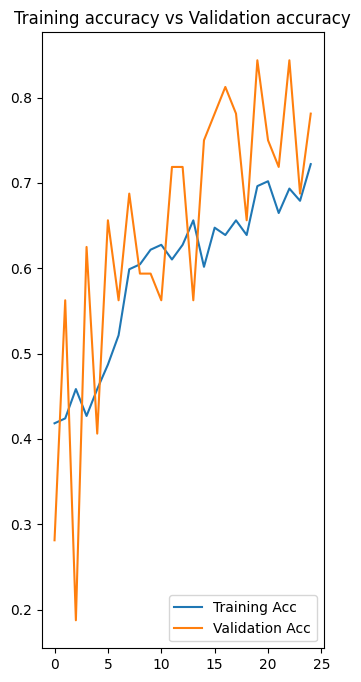

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title("Training accuracy vs Validation accuracy")
plt.plot(range(EPOCHS), history.history['accuracy'], label = 'Training Acc')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label = 'Validation Acc')
plt.legend(loc='lower right')
plt.title("Training accuracy vs Validation accuracy")

plt.show()

actual labelqq: pest
1/1 [==============================] - 0s 47ms/step
predicted label: pest
actual labelqq: Dots
1/1 [==============================] - 0s 47ms/step
predicted label: Dots


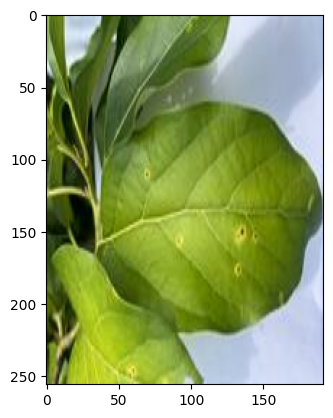

In [ ]:
for images_batch, labels_batch in testingSet.take(2):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("actual label:",classesList[first_label])

    prediction = model.predict(images_batch)
    print("predicted label:",classesList[np.argmax(prediction[0])])

In [ ]:
model_path = '/content/drive/My Drive/pest_disease.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model(model_path, compile=False)

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classesList[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


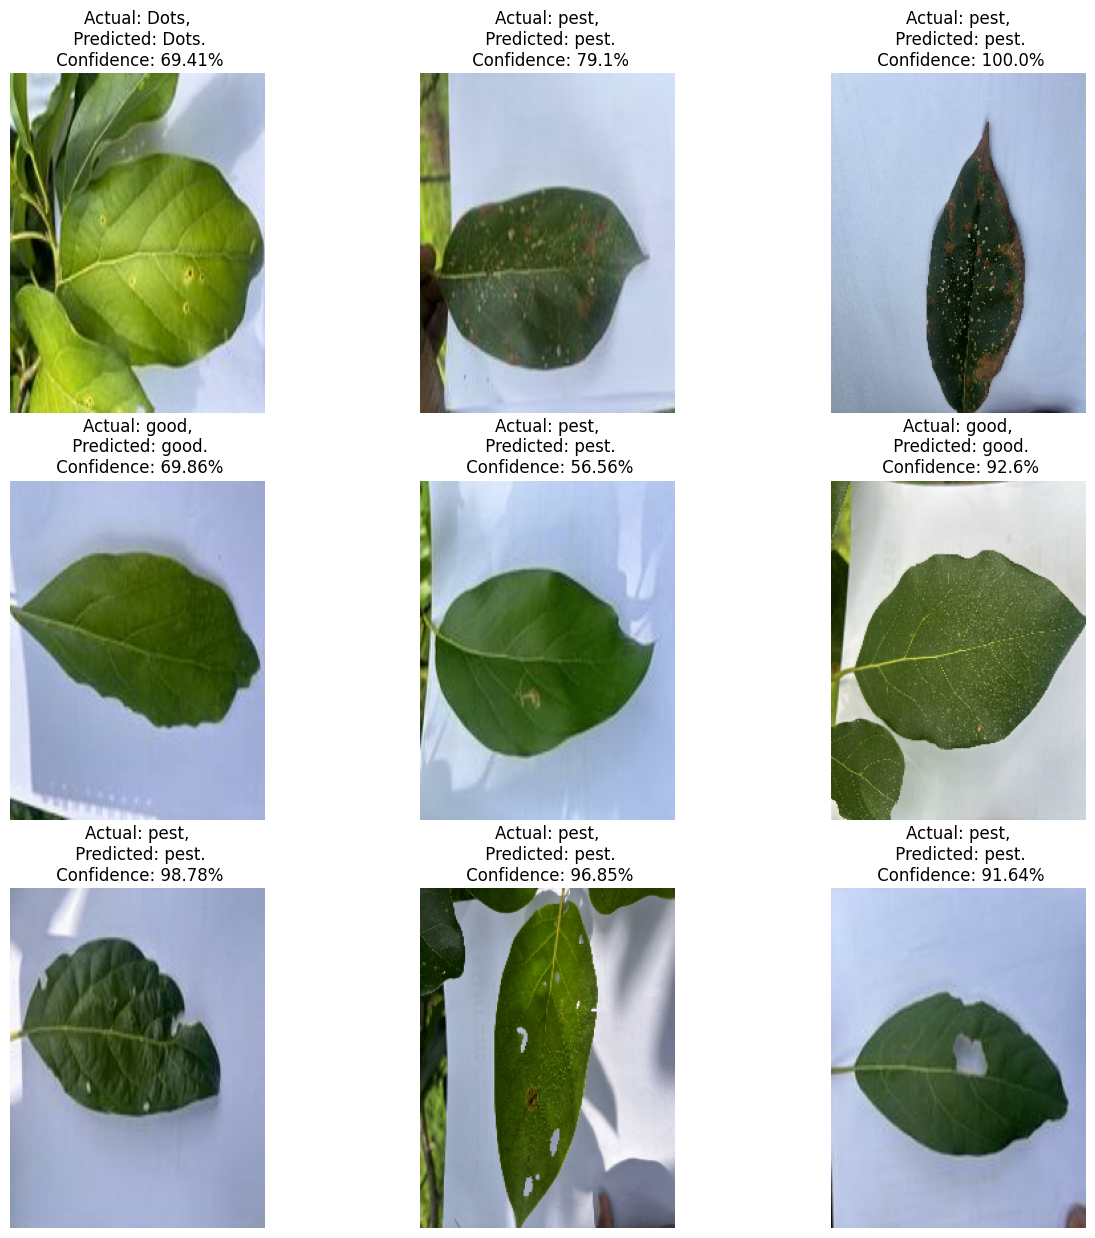

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in testingSet.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classesList[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")